In [11]:
import sys
sys.path.append("/home/gerald/Documents/CPD/repository/LifelongInformationRetrieval") # go to parent dir


In [12]:
import torch
import torch
import random
import torchvision
import torchvision.transforms as transforms
from torch import nn 
from torch import optim
from lire.function_tools import gradient_tools
from lire.continual_models import ewc

from matplotlib import pyplot as plt

## Splitting Dataset

Consider $Y=\{1,2,\dots, n\}$, we randomly split classes into couple of classes such $Y_k \subset Y$ with $|Y_k| = 2$.

In [13]:

from torch.utils.data import Dataset

data_transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.5,), (0.5,)),
                               lambda x : x.view(-1)]
)
dataset = torchvision.datasets.MNIST
training_data = dataset("../data", train=True, transform=data_transform)
testing_data = dataset("../data", train=False, transform=data_transform)

class IndexSet(Dataset):
    def __init__(self, data, index_data):
        super(IndexSet).__init__()
        self.data = data
        self.index_data = index_data

    def __getitem__(self, index):
        x, y = self.data[self.index_data[index]]
        return (x, y)
    
    def __len__(self):
        return len(self.index_data)


print("Building tasks")
sub_classes = torch.randperm(10)
sub_classes = [sub_classes[0:2].tolist(),
               sub_classes[2:4].tolist(),
               sub_classes[4:6].tolist(),
               sub_classes[6:8].tolist(),
               sub_classes[8:].tolist()]
tasks_training = [IndexSet(training_data, [i for i, (x,y) in enumerate(training_data) if(y in task_class)]) for task_class in sub_classes]

tasks_testing = [IndexSet(testing_data, [i for i, (x,y) in enumerate(testing_data) if(y in task_class)]) for task_class in sub_classes]


Building tasks


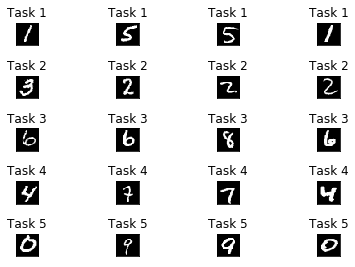

In [14]:
n_image_by_task = 4
for task_index, task_data in enumerate(tasks_training):
    for i in range(n_image_by_task):
        plt.subplot(len(tasks_training),n_image_by_task, task_index * n_image_by_task + i + 1)
        plt.tight_layout()
        rand = random.randint(0, len(task_data) -1 )
        plt.imshow(task_data[rand][0].reshape(28,28), cmap='gray', interpolation='none')
        plt.title("Task "+str(task_index+1))
        plt.xticks([])
        plt.yticks([])       


## Create model

In [15]:
encoder_1 = nn.Linear(784, 400)
encoder_2 = nn.Linear(400, 400)
classifier = nn.Linear(400, 10)
model = nn.Sequential(encoder_1, nn.ReLU(), encoder_2, nn.ReLU(), classifier)
model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=3e-2)

## Learning Loop

In [16]:
epoch = 10
log = {str(i): {"x" : [], "y" : []} for i in range(len(tasks_training))}
for task_index, task_training in enumerate(tasks_training):
    print("loading task ", task_index)
    dataloader = torch.utils.data.DataLoader(task_training, batch_size=1024, shuffle=True)

    for v in range(epoch):
        print(v)
        for task_index_test in range(0, task_index+1):
            with torch.no_grad():

                dataloader_test = torch.utils.data.DataLoader(tasks_testing[task_index_test], batch_size=500, shuffle=True)
                classification_score = 0.
                for x, y in dataloader_test:
                    y_pred = model(x.cuda())
                    _, index = y_pred.max(-1)
                    classification_score += (index == y.cuda()).sum()

                log[str(task_index_test)]["x"].append(task_index * epoch + v)
                log[str(task_index_test)]["y"].append(classification_score/len(dataloader_test.dataset) )
    
        for x, y in dataloader:
            optimizer.zero_grad()
            y_pred = model(x.cuda())
            loss = criterion(y_pred, y.cuda())
            
            loss.backward()
            optimizer.step()

loading task  0
0
1
2
3
4
5
6
7
8
9
loading task  1
0
1
2
3
4
5
6
7
8
9
loading task  2
0
1
2
3
4
5
6
7
8
9
loading task  3
0
1
2
3
4
5
6
7
8
9
loading task  4
0
1
2
3
4
5
6
7
8
9


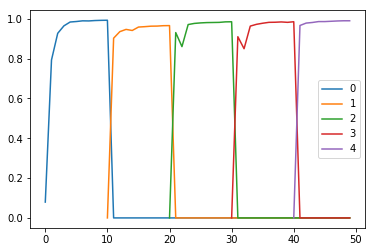

In [17]:
from matplotlib import pyplot as pyplot

for name, data in log.items():
    plt.plot(data["x"], data["y"], label=name)
plt.legend()

In [18]:
encoder_1 = nn.Linear(784, 400)
encoder_2 = nn.Linear(400, 400)
classifier = nn.Linear(400, 10)
model = nn.Sequential(encoder_1, nn.ReLU(), encoder_2, nn.ReLU(), classifier)
model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=3e-2)

epoch = 10
log_ewc = {str(i): {"x" : [], "y" : []} for i in range(len(tasks_training))}
class LogProbModel(nn.Module):
    def __init__(self, model, criterion):
        super(LogProbModel, self).__init__()
        self.model = model
        self.criterion = criterion
    
    def forward(self, data):
        x, y = data
        y_pred = self.model(x.cuda().unsqueeze(0))
        log_prob = self.criterion(y_pred, torch.LongTensor([y]).cuda())
        return log_prob

log_prob_model = LogProbModel(model, criterion)
ewc_model = ewc.EWC(log_prob_model)

for task_index, task_training in enumerate(tasks_training):
    print("loading task ", task_index)
    if(task_index > 0):
        ewc_model.next_task(tasks_training[task_index-1], log_prob_model)
    dataloader = torch.utils.data.DataLoader(task_training, batch_size=1024, shuffle=True)

    for v in range(epoch):
        print(v)
        for task_index_test in range(0, task_index+1):
            with torch.no_grad():

                dataloader_test = torch.utils.data.DataLoader(tasks_testing[task_index_test], batch_size=500, shuffle=True)
                classification_score = 0.
                for x, y in dataloader_test:
                    y_pred = model(x.cuda())
                    _, index = y_pred.max(-1)
                    classification_score += (index == y.cuda()).sum()

                log_ewc[str(task_index_test)]["x"].append(task_index * epoch + v)
                log_ewc[str(task_index_test)]["y"].append(classification_score/len(dataloader_test.dataset) )
    
        for x, y in dataloader:
            optimizer.zero_grad()
            y_pred = model(x.cuda())
            loss = criterion(y_pred, y.cuda())
            if(task_index > 0):
                loss += 100. *  ewc_model.ewc_loss()
            loss.backward()
            optimizer.step()

loading task  0
0
1
2
3
4
5
6
7
8
9
loading task  1
0
1
2
3
4
5
6
7
8
9
loading task  2
0
1
2
3
4
5
6
7
8
9
loading task  3
0
1
2
3
4
5
6
7
8
9
loading task  4
0
1
2
3
4
5
6
7
8
9


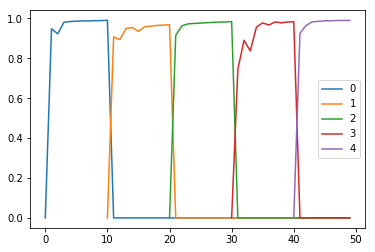

In [19]:
from matplotlib import pyplot as pyplot

for name, data in log_ewc.items():
    plt.plot(data["x"], data["y"], label=name)
plt.legend()

In [21]:
f = lambda log, t : (sum(list(map(lambda x: x["y"][t], log.values())), 0.)/5*1000).item()//1/10.
print("Mean accuracy FT  ", f(log, -1))
print("Mean accuracy EWC ", f(log_ewc, -1))

Mean accuracy FT   19.7
Mean accuracy EWC  19.7
